In [13]:
import matplotlib.pyplot as plt
from CODE.utils import *
from CODE.models import create_2f_model


In [14]:
window_size = 10
n_units = 256
corr_threshold = 0.2

df = load_dfs()
diff_df = df.pct_change(1).iloc[1:,:]

correlations = diff_df.corr().values[0]
filteres_ids = np.argwhere(abs(correlations)> corr_threshold).flatten()
diff_df = diff_df.iloc[:,filteres_ids]
print(diff_df.head())

                AAON      ACIW      ADTN      ANSS      ATNI      MSFT  \
Date                                                                     
1999-03-16  0.000000  0.020903  0.007109  0.000000 -0.027778  0.019170   
1999-03-17 -0.006200 -0.014156 -0.014706  0.016259  0.014286 -0.011416   
1999-03-18  0.000000  0.000000  0.007761  0.003968 -0.042254  0.031772   
1999-03-19  0.050513 -0.059231 -0.007701 -0.027919  0.014706 -0.007249   
1999-03-22  0.005747 -0.001635  0.014925  0.016393  0.014493  0.009463   

                SRCE      UHAL  
Date                            
1999-03-16  0.010471 -0.032506  
1999-03-17 -0.004210 -0.049514  
1999-03-18  0.008130  0.034884  
1999-03-19 -0.006129 -0.044944  
1999-03-22  0.006167  0.035294  


In [15]:

file = 'FILES/Models/lstm_2f_model.hdf5'
rf_num = diff_df.values.shape[1]
input_shape = (window_size,rf_num)
model = create_2f_model(n_units, input_shape, file)

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 542720      input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 512)          0           bidirectional_1[0][2]      

In [16]:
X1, X2, Y = generate_windows_for_two_factor(diff_df, window_size)
X1[0:10]
X2[0:10]
Y[0:10]

array([ 0.02272727, -0.04444444,  0.02325581, -0.01090909,  0.        ,
       -0.01194853, -0.02325581,  0.        ,  0.04761905,  0.01181818])

In [24]:
epochs = 1000
for i in range(epochs):
    hist = model.fit(x=[X1, X2],
              y=Y,
              batch_size=512,
              verbose=0,
              epochs=1,
              validation_split=0.05,
              callbacks=[])
    if i > 0:
        if hist.history['val_loss'][-1] < val_loss:
            val_loss = hist.history['val_loss'][-1]
            print("New best val_loss: {}\t epoch: {}".format(val_loss,i))
            model.save_weights(file)
    else:
        val_loss = hist.history['val_loss'][-1]


New best val_loss: 0.00036128019564785063	 epoch: 2


New best val_loss: 0.0003521296021062881	 epoch: 3


New best val_loss: 0.00034580641658976674	 epoch: 10


New best val_loss: 0.00034039028105325997	 epoch: 125


New best val_loss: 0.0003393094229977578	 epoch: 315


New best val_loss: 0.00032269570510834455	 epoch: 428


In [18]:
start = 100
window = 100
test_df = df.iloc[0:300,0].to_frame()
test_df.columns=['Actual']
test_df['Interp'] = test_df.iloc[:,0]
test_df['Interp'].iloc[start:start+window]=np.nan
test_df = test_df.interpolate()
start_value = test_df.iloc[start-1,0]
end_value = test_df.iloc[start+window,0]

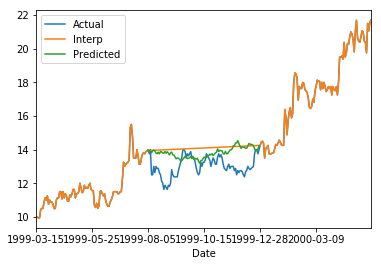

In [19]:
Y_pred, Y_actual=list(), list()
for id in range(start, start+window):
    if id == start:
        x2 = X2[id].reshape(-1, window_size - 1, 1)
    x1 = X1[id].reshape(-1,window_size,input_shape[1]-1)
    Y_pred.append(model.predict([x1, x2]).flatten())
    Y_actual.append(Y[id].flatten())
    x2[0, :-1, 0] = x2[0, 1:, 0]
    x2[0,-1,0] = Y_pred[-1]

test_df['Predicted']=np.nan
fixed_values = np.array(Y_pred)+1
for i, value in enumerate(fixed_values):
    if i == 0:
        fixed_values[0]=value*start_value
    else:
        fixed_values[i]=fixed_values[i-1]*value
multiplier = end_value/fixed_values[-1]
singlemultipliers = np.array([multiplier**(x/(window+1)) for x in range(window+2)])
#singlemultipliers = np.array([multiplier**(0) for x in range(window+2)])
test_df['Predicted'].iloc[start:start+100]=fixed_values[:, 0]*singlemultipliers[:-2, 0]
test_df.plot()


In [20]:
import matplotlib.pyplot as plt
compare_df = test_df.dropna().copy()
compare_df['LinInterpDiffs']=abs(compare_df['Actual']-compare_df['Interp'])/compare_df['Actual']
compare_df['LstmPredDiffs']=abs(compare_df['Actual']-compare_df['Predicted'])/compare_df['Actual']
print(compare_df.head())

            Actual     Interp  Predicted  LinInterpDiffs  LstmPredDiffs
Date                                                                   
1999-08-05   14.00  13.943069  13.900264        0.004066       0.007124
1999-08-06   13.75  13.946139  13.932294        0.014265       0.013258
1999-08-09   14.00  13.949208  13.929334        0.003628       0.005048
1999-08-10   12.50  13.952277  13.811050        0.116182       0.104884
1999-08-11   12.50  13.955347  13.919684        0.116428       0.113575


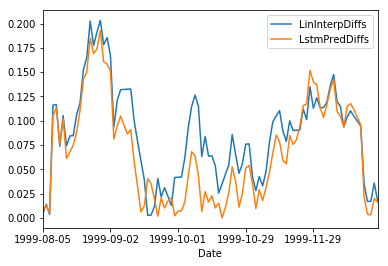

In [21]:
compare_df.loc[:,['LinInterpDiffs', 'LstmPredDiffs'] ].plot()

In [22]:
print("Lstm Average Error: {}".format(compare_df['LstmPredDiffs'].mean()))
print("Interpolation Average Error: {}".format(compare_df['LinInterpDiffs'].mean()))

Lstm Average Error: 0.06794398464009141
Interpolation Average Error: 0.08525966215000286


In [23]:
from scipy import stats

resLstm = stats.ks_2samp(compare_df['Actual'].values, compare_df['Predicted'].values)
print("Lstm KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resLstm.statistic, resLstm.pvalue))
resInterp = stats.ks_2samp(compare_df['Actual'].values, compare_df['Interp'].values)
print("Interp KS result: \n \t - Statistic: {0} \n \t - pvalue: {1}".format(resInterp.statistic, resInterp.pvalue))

Lstm KS result: 
 	 - Statistic: 0.67 
 	 - pvalue: 1.1243649322654801e-20
Interp KS result: 
 	 - Statistic: 0.93 
 	 - pvalue: 1.9271763142799626e-39
